In [9]:

#!/usr/local/anaconda3/bin/python3
# imports
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.templates import AmplitudeEmbedding
import matplotlib.pyplot as plt

from math import sqrt, pi

from qiskit.visualization import plot_state_qsphere

import warnings
warnings.simplefilter('ignore')



Settings

In [4]:
##################################
# settings
iterations = 75

# batch size and optimizer
opt = NesterovMomentumOptimizer(0.01)

batch_size = 5

##################################
# define functions
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )
    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss


def cost(classifier, weights, features, labels):
    predictions = [classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

def plot_costs(costs, num_layers):
  # plot costs
   fig, (ax1) = plt.subplots(1)
   fig.suptitle('Costs')
   ax1.plot(range(iterations), costs, label='Layers: {}'.format(num_layers))
   ax1.set_xlabel('iteration number')
   ax1.set_ylabel('cost objective function')
   ax1.legend(loc="upper right")
   plt.show()


## Load data and create train and validation set

load the original iris data set with three classes

First 3 X sample (original)  : [[ 4.  20.   1.9]
 [ 6.  38.   1.1]
 [ 7.  20.   1.3]]
First 3 X sample (scaled)  : [[-1.62950241 -1.53055953  0.49005699]
 [-1.60369074 -0.00707675 -0.28455235]
 [-1.5907849  -1.53055953 -0.09090002]]
First 10 Y samples (original)  : [1 1 1 1 1 1 1 1 1 1]
First X sample (padded)    : [-1.62950241 -1.53055953  0.49005699  0.3       ]
First X sample (normalized): [-0.70594523 -0.66308045  0.21230616  0.12996824]
First features sample      : [ 0.50314858 -0.5493227   0.5493227  -0.75409796  0.75409796]
amplitude vector2:  [ 8.80392277e-01  5.72921893e-02  9.38089760e-02  6.10468964e-03
 -3.03072143e-01 -1.97226475e-02 -3.22934311e-02 -2.10151931e-03
 -3.24337278e-01 -2.11064922e-02 -3.45593081e-02 -2.24897296e-03
  1.11652040e-01  7.26584045e-03  1.18969280e-02  7.74201535e-04]
 0: ──RY(-0.706)──┤ ⟨Z⟩ 
 1: ──RY(-0.663)──┤     
 2: ──RY(0.212)───┤     
 3: ──RY(0.13)────┤     



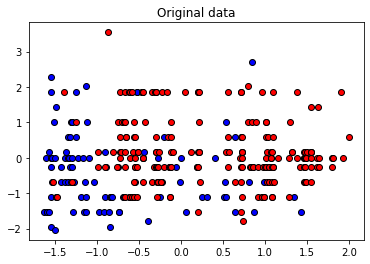

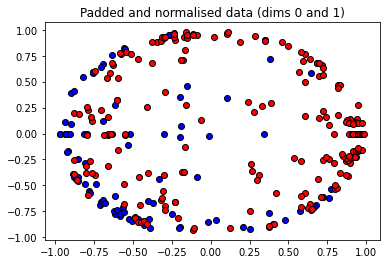

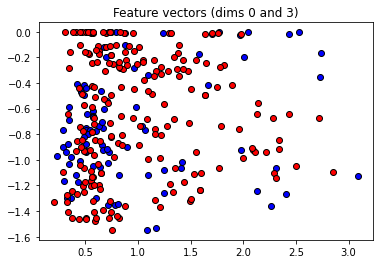

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize_data(data, frange=(-1,1)):
    return MinMaxScaler(feature_range=frange).fit_transform(data)

def scale_data(data, with_mean=True, with_std=True):
    return StandardScaler(with_mean=with_mean, with_std=with_std).fit_transform(data)

##################################
# load data

# Load the data and split it up
heart_data = pd.read_csv('data/kaggle/heart_failure_clinical_records_dataset.csv')
heart_data.head()

# use only these features
Features = ['time','ejection_fraction','serum_creatinine']

# get X data
X_orig = np.array(heart_data[Features])
X = scale_data(X_orig) # scale data

# get Y data
Y_orig = np.array(heart_data["DEATH_EVENT"])
Y = np.subtract(Y_orig, 1, out=Y_orig, where=Y_orig==0) # subtract 1 from all 0 values

print("First 3 X sample (original)  :", X_orig[0:3])
print("First 3 X sample (scaled)  :", X[0:3])
print("First 10 Y samples (original)  :", Y[0:10])

# padding
padding = 0.3 * np.ones((len(X), 1))
# # padding = np.zeros((len(X), 1)) # does not perform well when padded with only zeros
# X_pad = np.c_[np.c_[X,padding], np.zeros((len(X), 1))]
X_pad = np.c_[np.c_[X,padding]]
print("First X sample (padded)    :", X_pad[0])

# normalization
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

##################################
# test 

test_qubits=4

dev2 = qml.device("default.qubit", wires=test_qubits)
dev3 = qml.device("default.qubit", wires=test_qubits)

@qml.qnode(dev2)
def test2(x):
    # AmplitudeEmbedding(features=x, wires=range(test_qubits), normalize=False)
    qml.RY(x[0], wires=0)
    qml.RY(x[1], wires=1)
    qml.RY(x[2], wires=2)
    qml.RY(x[3], wires=3)
    return qml.expval(qml.PauliZ(0))

test2(X_norm[0])

print("amplitude vector2: ", np.real(dev2.state))
print(test2.draw())

##################################
# train and validation dataset
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)

index = np.random.permutation(range(num_data))

Y_train = Y[index[:num_train]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

##################################
# plot data
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()


In [6]:
##################################
# function to train the classifier
def train_classifier(classifier, circuit, features, initial_weights):
  var = initial_weights  
  feats_train = features[index[:num_train]] 
  feats_val = features[index[num_train:]] 

  costs = np.zeros(iterations)  # initialize costs array

  # Do for iterations
  for it in range(iterations):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, num_train, (batch_size,))
      feats_train_batch = feats_train[batch_index]
      Y_train_batch = Y_train[batch_index]

      var = opt.step(lambda v: cost(classifier, v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(classifier(var, f)) for f in feats_train]
      predictions_val = [np.sign(classifier(var, f)) for f in feats_val]

      # Compute accuracy on train and validation set
      acc_train = accuracy(Y_train, predictions_train)
      acc_val = accuracy(Y_val, predictions_val)

      # gather informations for plotting
      costs[it] = cost(classifier, var, features, Y)

      print(
          "2 Qubits => Iter: {:5d} | Overall cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(it + 1, costs[it], acc_train, acc_val)
      )

  if dev.short_name == "qiskit.aer":
      #display(dev_4qubits._circuit_4qubits.draw(output="mpl"))
      print(dev._circuit.draw())
  else:
      # if device is "default.qubit"
      print(circuit.draw())

  return costs


Define circuit and run classifier 

2 Qubits => Iter:     1 | Overall cost: 2.1432806 | Acc train: 0.3080357 | Acc validation: 0.3600000 
2 Qubits => Iter:     2 | Overall cost: 2.0274433 | Acc train: 0.3080357 | Acc validation: 0.3600000 
2 Qubits => Iter:     3 | Overall cost: 1.8514190 | Acc train: 0.3080357 | Acc validation: 0.3600000 
2 Qubits => Iter:     4 | Overall cost: 1.6690398 | Acc train: 0.3080357 | Acc validation: 0.3600000 
2 Qubits => Iter:     5 | Overall cost: 1.4521115 | Acc train: 0.3080357 | Acc validation: 0.3600000 
2 Qubits => Iter:     6 | Overall cost: 1.2227573 | Acc train: 0.4910714 | Acc validation: 0.5866667 
2 Qubits => Iter:     7 | Overall cost: 1.0194580 | Acc train: 0.5937500 | Acc validation: 0.5866667 
2 Qubits => Iter:     8 | Overall cost: 0.8863722 | Acc train: 0.6294643 | Acc validation: 0.6266667 
2 Qubits => Iter:     9 | Overall cost: 0.7889107 | Acc train: 0.6517857 | Acc validation: 0.6666667 
2 Qubits => Iter:    10 | Overall cost: 0.7114317 | Acc train: 0.6830357 | Acc val

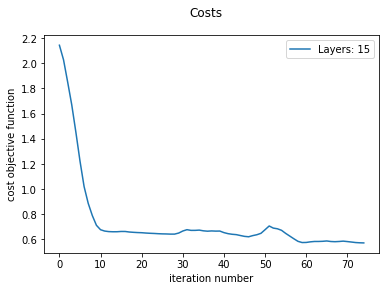

In [7]:
# qubits
qubits=4
# layers
num_layers = 15
# weights per qubit per layer
num_weights=3

# quantum devices
dev = qml.device("default.qubit", wires=qubits)
#dev = qml.device("qiskit.aer", wires=qubits)

# layers, circuit and classifier
# amplitude embedding
def statepreparation(f):
    qml.RY(f[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(f[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(f[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(f[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(f[4], wires=1)
    qml.PauliX(wires=0)

def amplitudeEmbedding(f):
    AmplitudeEmbedding(features=f, wires=range(qubits))
    # AmplitudeEmbedding(features=f, wires=range(qubits), normalize=True, pad=0.33)

def oneFeaturePerQubit(f):
    qml.RY(f[0], wires=0)
    qml.RY(f[1], wires=1)
    qml.RY(f[2], wires=2)
    qml.RY(f[3], wires=3)
  
def layer(weights):
    qml.Rot(weights[0, 0], weights[0, 1], weights[0, 2], wires=0)
    qml.Rot(weights[1, 0], weights[1, 1], weights[1, 2], wires=1)
    qml.Rot(weights[2, 0], weights[2, 1], weights[2, 2], wires=2)
    qml.Rot(weights[2, 0], weights[3, 1], weights[3, 2], wires=3)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev)
def circuit(weights, features):
    # statepreparation(features)
    # amplitudeEmbedding(features)
    oneFeaturePerQubit(features)
    for W in weights:
        layer(W)
    return qml.expval(qml.PauliZ(0)) 

def classifier(var, features):
    weights = var[0]
    bias = var[1]
    return circuit(weights, features) + bias

# init weights
initial_weights = var_init = (0.01 * np.random.randn(num_layers, qubits, num_weights), 0.0) 

costs = train_classifier(classifier, circuit, X_norm, initial_weights)

# plot costs
plot_costs(costs, num_layers)


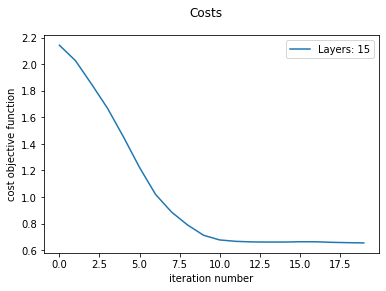

In [8]:

showCount = 20
fig, (ax1) = plt.subplots(1)
fig.suptitle('Costs')
ax1.plot(range(showCount), costs[0:showCount], label='Layers: {}'.format(num_layers))
ax1.set_xlabel('iteration number')
ax1.set_ylabel('cost objective function')
ax1.legend(loc="upper right")
plt.show()